In [194]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import math
import networkx as nx
from tqdm import tqdm
from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid
from sklearn.decomposition import NMF
from tigramite import plotting as tp
import json

from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans, SpectralClustering

In [195]:
from expbasics.network_binary import train_network as train_network_binary
from expbasics.network import train_network as train_network, accuracy_per_class
from expbasics.biased_dsprites_dataset import get_test_dataset, get_biased_loader, BiasedDSpritesDataset
from expbasics.crp_hierarchies import sample_from_categories
from expbasics.network import train_network, accuracy_per_class
from expbasics.ground_truth_measures import GroundTruthMeasures
from expbasics.crp_attribution import CRPAttribution, vis_simple

%reload_ext autoreload
%autoreload 2

{0: Counter({False: 191315, True: 54445}), 1: Counter({True: 191542, False: 54218})}


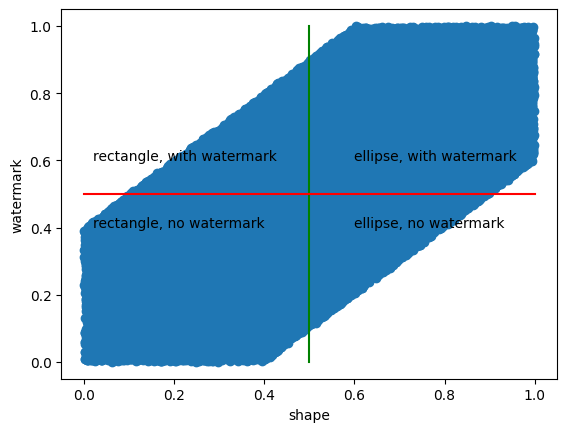

In [202]:
BIAS = 0.6
STRENGTH = 0.5
BATCH_SIZE = 128
LR = 0.001
NAME = "../clustermodels/bigm"

train_loader = get_biased_loader(BIAS, 0.5, batch_size=BATCH_SIZE, verbose=True)
model = train_network(
    train_loader,
    BIAS,
    STRENGTH,
    NAME,
    BATCH_SIZE,
    load=True,
    retrain=False,
    learning_rate=LR,
    epochs=3
)
unb_short, unbiased_ds, test_loader = get_test_dataset(split=0.1)

gm = GroundTruthMeasures()
crp_attribution = CRPAttribution(model, unbiased_ds, "nmf", STRENGTH, BIAS)



In [2]:
flipvalues = gm.ols_values(model)
ols_vals = gm.ordinary_least_squares(flipvalues)
mean_logit = gm.mean_logit_change(flipvalues)
flip_pred = gm.ols_prediction_values(model)
ols_pred = gm.ordinary_least_squares_prediction(flip_pred)
mean_logit_pred = gm.mean_logit_change_prediction(flip_pred)

NameError: name 'gm' is not defined

In [228]:
with open("outputs/measures.json", "r") as f:
    analysis_data = json.load(f)
    alldata = sorted(analysis_data.values(), key=lambda x: x["bias"])
    biases = [a["bias"] for a in alldata]
colors = mpl.cm.gist_rainbow(np.linspace(0, 1, 10))  # gist_ncar
styles = ["solid", "dotted", "dashed", "dashdot"]

In [229]:
filtbiases = [
    a["bias"] for a in list(filter(lambda x: x["learning_rate"] == 0.001, alldata))
]
datas =[[],[],[],[]]
datas[0] = list(filter(lambda x: x["learning_rate"] == 0.001, alldata))

datas[1] = list(filter(lambda x: x["learning_rate"] == 0.0015, alldata))

datas[2] = list(filter(lambda x: x["learning_rate"] == 0.002, alldata))

datas[3] = list(filter(lambda x: x["learning_rate"] == 0.0005, alldata))

In [126]:
# REDUCE BIAS INTERVAL
b = 0.6
filtbiases = [
    a["bias"] for a in list(filter(lambda x: x["learning_rate"] == 0.001 and x["bias"] > b, alldata))
]
datas =[[],[],[],[]]
datas[0] = list(filter(lambda x: x["learning_rate"] == 0.001 and x["bias"] > b, alldata))

datas[1] = list(filter(lambda x: x["learning_rate"] == 0.0015 and x["bias"] > b, alldata))

datas[2] = list(filter(lambda x: x["learning_rate"] == 0.002 and x["bias"] > b, alldata))

datas[3] = list(filter(lambda x: x["learning_rate"] == 0.0005 and x["bias"] > b, alldata))

In [230]:
factornames = gm.latents_names
factornames[0] = "watermark"

/tmp/ipykernel_59362/1296005782.py:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


Text(0.5, 1.0, 'watermark Mean Logit Change lr: 0.0005')

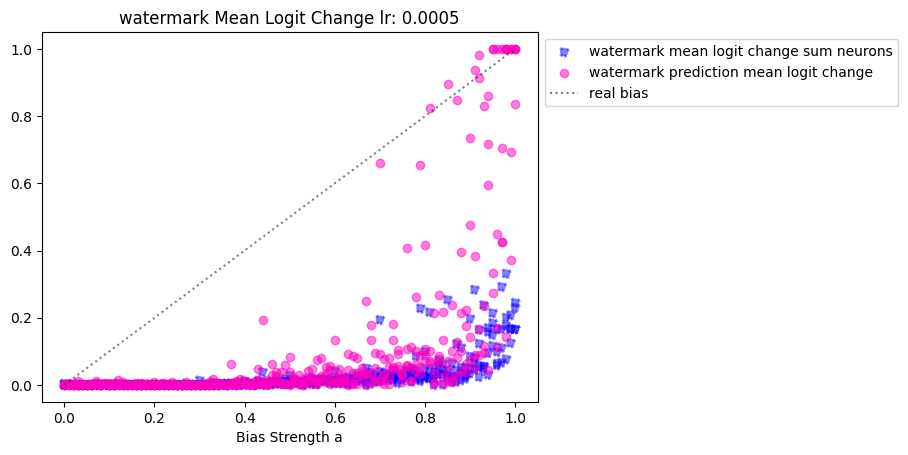

In [231]:
def plot_linear_layer(items, biasitems, factor=0):
    plt.scatter(
        biasitems,
        [np.sum(a["crp_mean_logit_change"][0]) / 6 for a in items],
        c=colors[7],
        label=f"{factornames[factor]} mean logit change sum neurons",
        linestyle="dotted",
        linewidth=2,
        alpha=0.5,
    )
    plt.scatter(
        biasitems,
        [a["pred_mean_logit_change"][factor] for a in items],
        color=colors[9],
        label=f"{factornames[factor]} prediction mean logit change",
        alpha=0.5,
    )
    """ for i in range(6):
        plt.scatter(
            biasitems,
            [a["crp_mean_logit_change"][factor][i] for a in items],
            color=colors[i],
            label=f"{factornames[factor]} mean logit change neuron {i}",
            alpha=0.5,
        ) """
    plt.plot(
        biasitems,
        biasitems,
        color="#000",
        label="real bias",
        linestyle="dotted",
        alpha=0.5,
    )

factor = 0
lrindex = 0
lrs = [0.0005, 0.001, 0.0015, 0.002]
lr = lrs[lrindex]
# plot_linear_layer(datas[lrindex], filtbiases, factor)
plot_linear_layer(alldata, biases)
plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Bias Strength a")
plt.title(f"{factornames[factor]} Mean Logit Change lr: {lr}")

Text(0.5, 1.0, 'watermark Mean Logit Change Summed over learning rates')

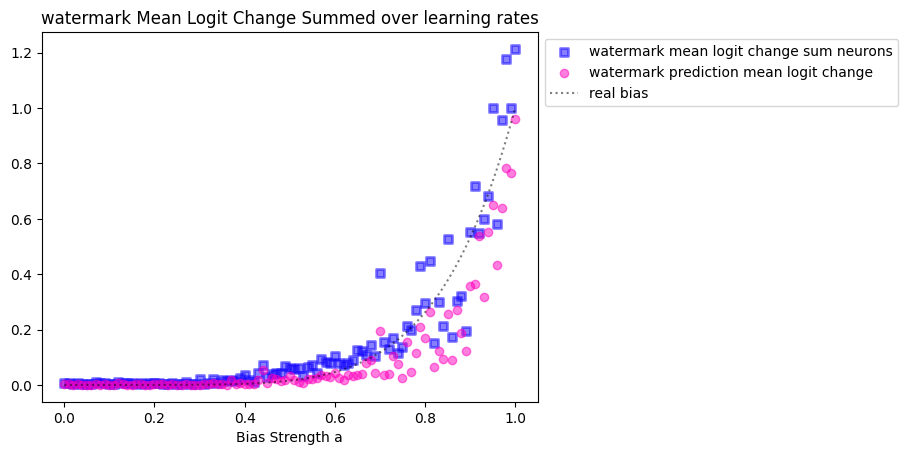

In [232]:
def plot_linear_layer(items, biasitems, factor=0):
    summed_neurons = [
        np.sum([datas[a][i]["crp_mean_logit_change"][factor] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_prediction = [
        np.sum([datas[a][i]["pred_mean_logit_change"][factor] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    plt.scatter(
        biasitems,
        summed_neurons,
        color=colors[7],
        label=f"{factornames[factor]} mean logit change sum neurons",
        marker="s",
        linewidth=2,
        alpha=0.5,
    )
    plt.scatter(
        biasitems,
        summed_prediction,
        color=colors[9],
        label=f"{factornames[factor]} prediction mean logit change",
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        [i**6 for i in biasitems],
        color="#000",
        label="real bias",
        linestyle="dotted",
        alpha=0.5,
    )


factor = 0
plot_linear_layer(datas, filtbiases)
plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Bias Strength a")
plt.title(f"{factornames[factor]} Mean Logit Change Summed over learning rates")

101 101
101 101
101 101
101 101


Text(0.5, 1.0, 'watermark Mean Logit Change Summed over learning rates')

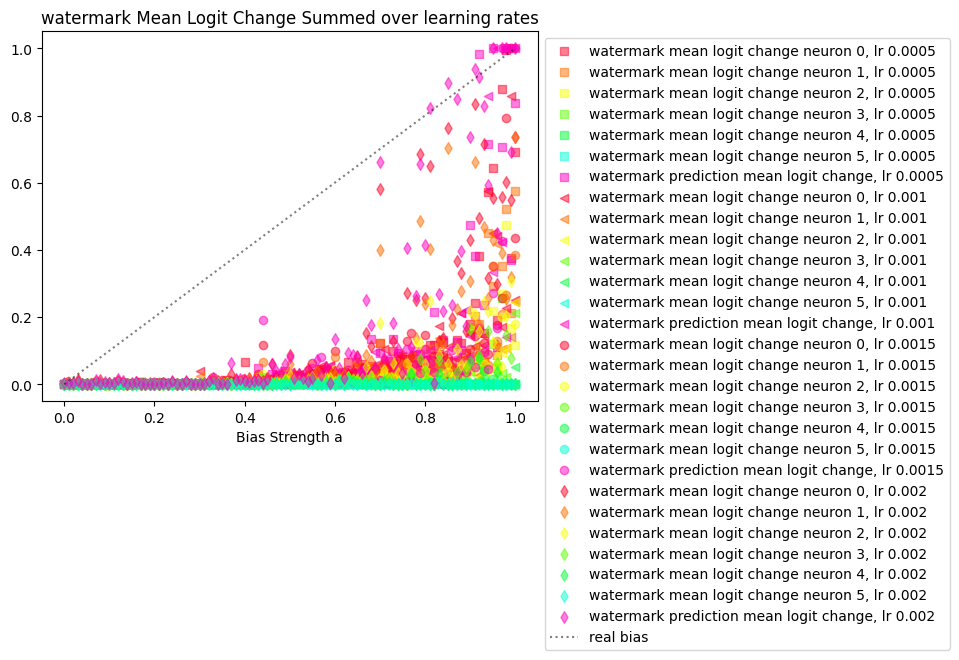

In [233]:
def plot_linear_layer(items, biasitems, factor=0):
    shapes = ["s", "<", "o", "d"]
    for i in range(4):
        print(len(items[i]), len(biasitems))
        sort_vals = [sorted([a["crp_mean_logit_change"][factor][n] for n in range(6)], reverse=True) for a in items[i]]
        for n in range(0,6):
            vals = [a[n] for a in sort_vals]
            #[a["crp_mean_logit_change"][factor][n] for a in items[i]]
            plt.scatter(
                biasitems,
                vals,
                color=colors[n],
                label=f"{factornames[factor]} mean logit change neuron {n}, lr {lrs[i]}",
                marker=shapes[i],
                alpha=0.5,
            )
        plt.scatter(
            biasitems,
            [a["pred_mean_logit_change"][factor] for a in items[i]],
            color=colors[9],
            label=f"{factornames[factor]} prediction mean logit change, lr {lrs[i]}",
            marker=shapes[i],
            alpha=0.5,
        )
    plt.plot(
        biasitems,
        biasitems,
        color="#000",
        label="real bias",
        linestyle="dotted",
        alpha=0.5,
    )


factor = 0
plot_linear_layer(datas, filtbiases,factor)
plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Bias Strength a")
plt.title(f"{factornames[factor]} Mean Logit Change Summed over learning rates")

Text(0.5, 1.0, 'Mean Logit Change Watermark vs Shape Summed over learning rates and neuron(s) 0')

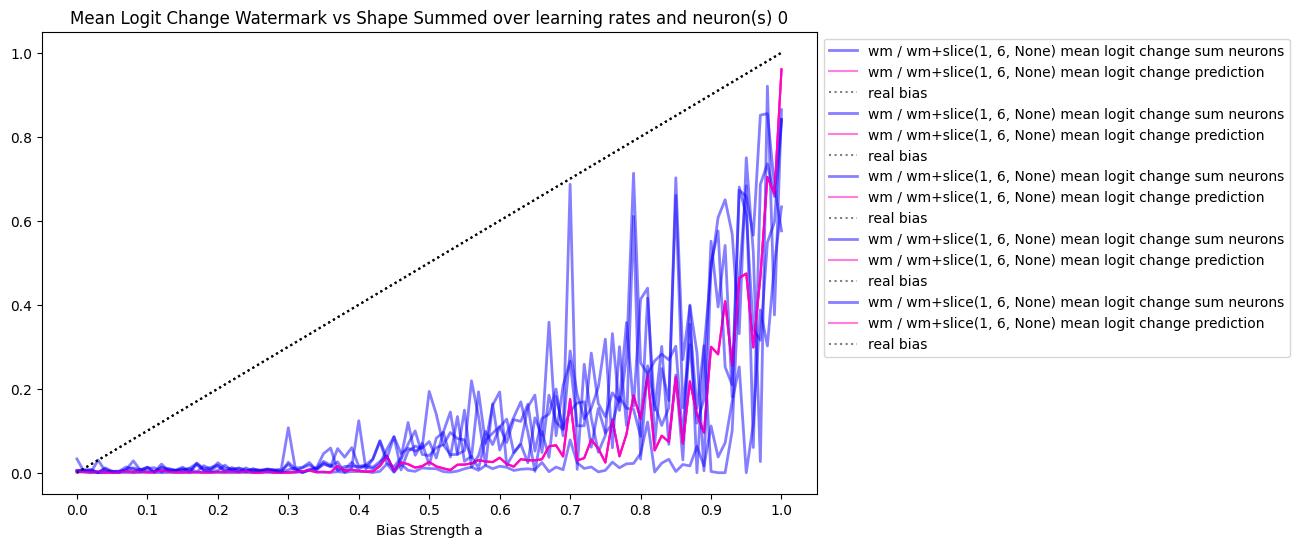

In [234]:
def plot_linear_layer(items, biasitems, neuron, f1, f2):
    summed_wm = [
        np.sum([datas[a][i]["crp_mean_logit_change"][f1][neuron] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_sh = [
        np.sum([datas[a][i]["crp_mean_logit_change"][f2][neuron] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_neurons = [
        summed_wm[i] / (summed_wm[i] + summed_sh[i]) for i in range(len(summed_wm))
    ]
    summed_p_wm = [
        np.sum([datas[a][i]["pred_mean_logit_change"][f1] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_p_sh = [
        np.sum([datas[a][i]["pred_mean_logit_change"][f2] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_prediction = [
        summed_p_wm[i] / (summed_p_wm[i] + summed_p_sh[i])
        for i in range(len(summed_wm))
    ]
    plt.plot(
        biasitems,
        summed_neurons,
        color=colors[7],
        label=f"wm / wm+{f2} mean logit change sum neurons",
        linewidth=2,
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        summed_prediction,
        color=colors[9],
        label=f"wm / wm+{f2} mean logit change prediction",
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        biasitems,
        color="#000",
        label="real bias",
        linestyle="dotted",
        alpha=0.5,
    )


neuron = 0#slice(0, 6)
f1 = 0
f2 = 1

plt.figure(figsize=(10,6))
plot_linear_layer(datas, filtbiases, neuron, f1, slice(1, 6))
plot_linear_layer(datas, filtbiases, 1, f1, slice(1, 6))
plot_linear_layer(datas, filtbiases, 2, f1, slice(1, 6))
plot_linear_layer(datas, filtbiases, 3, f1, slice(1, 6))
plot_linear_layer(datas, filtbiases, 4, f1, slice(1, 6))
#plot_linear_layer(datas, filtbiases, 5, f1, slice(1, 6))
# plot_linear_layer(datas, filtbiases, neuron, f2, f1)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Bias Strength a")
plt.xticks(np.arange(0,1.1,0.1))
plt.title(
    f"Mean Logit Change Watermark vs Shape Summed over learning rates and neuron(s) {neuron}"
)

Text(0.5, 1.0, 'Mean Logit Change Watermark vs Shape Summed over learning rates and neuron(s) slice(0, 6, None)')

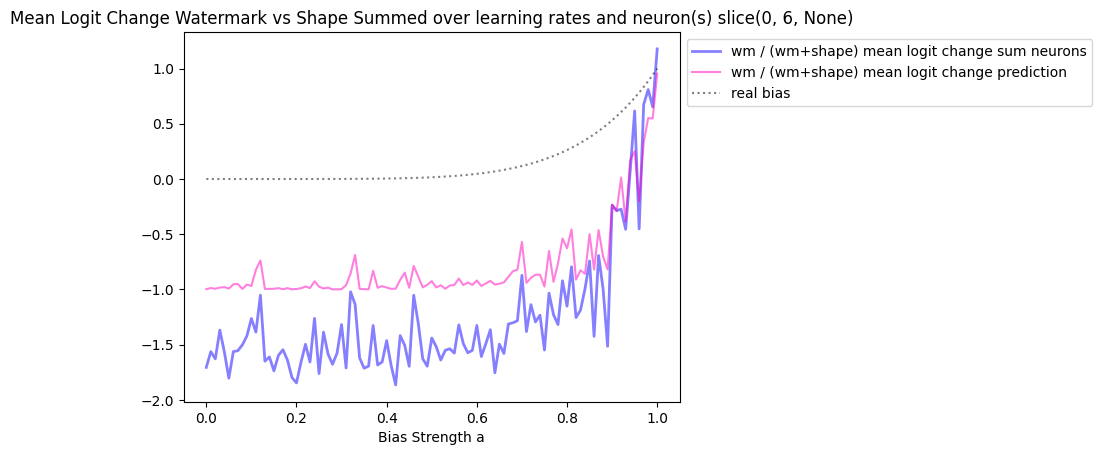

In [235]:
def plot_linear_layer(items, biasitems, neuron, f1, f2):
    summed_wm = [
        np.sum([datas[a][i]["crp_mean_logit_change"][f1][neuron] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_sh = [
        np.sum([datas[a][i]["crp_mean_logit_change"][f2][neuron] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_neurons = [(summed_wm[i] - summed_sh[i]) for i in range(len(summed_wm))]
    summed_p_wm = [
        np.sum([datas[a][i]["pred_mean_logit_change"][f1] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_p_sh = [
        np.sum([datas[a][i]["pred_mean_logit_change"][f2] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_prediction = [
        (summed_p_wm[i] - summed_p_sh[i]) for i in range(len(summed_wm))
    ]
    plt.plot(
        biasitems,
        summed_neurons,
        color=colors[7],
        label=f"wm / (wm+shape) mean logit change sum neurons",
        linewidth=2,
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        summed_prediction,
        color=colors[9],
        label=f"wm / (wm+shape) mean logit change prediction",
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        [i**6 for i in biasitems],
        color="#000",
        label="real bias",
        linestyle="dotted",
        alpha=0.5,
    )


neuron = slice(0, 6)
f1 = 0
f2 = 1
plot_linear_layer(datas, filtbiases, neuron, f1, f2)
plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Bias Strength a")
plt.title(
    f"Mean Logit Change Watermark vs Shape Summed over learning rates and neuron(s) {neuron}"
)

Text(0.5, 1.0, 'Difference between summed neuron logit change and prediction logit change')

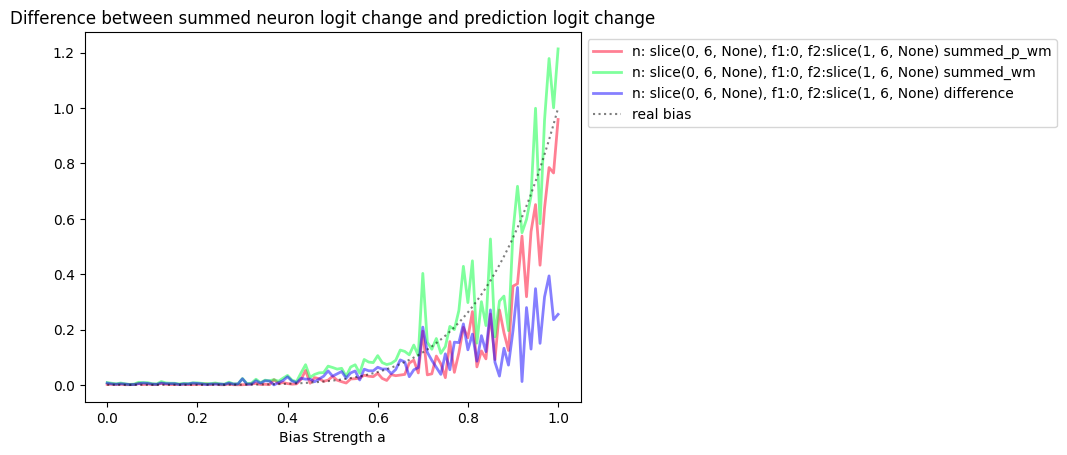

In [236]:
def plot_linear_layer(items, biasitems, neuron, f1, f2):
    summed_wm = [
        np.sum([datas[a][i]["crp_mean_logit_change"][f1][neuron] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_sh = [
        np.sum([datas[a][i]["crp_mean_logit_change"][f2][neuron] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_neurons = [(summed_wm[i] - summed_sh[i]) for i in range(len(summed_wm))]
    summed_p_wm = [
        np.sum([datas[a][i]["pred_mean_logit_change"][f1] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_p_sh = [
        np.sum([datas[a][i]["pred_mean_logit_change"][f2] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_prediction = [
        (summed_p_wm[i] - summed_p_sh[i]) for i in range(len(summed_wm))
    ]
    differences = [summed_wm[i] - summed_p_wm[i] for i in range(len(summed_neurons))]
    plt.plot(
        biasitems,
        summed_p_wm,
        color=colors[0],
        label=f"n: {neuron}, f1:{f1}, f2:{f2} summed_p_wm",
        linewidth=2,
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        summed_wm,
        color=colors[4],
        label=f"n: {neuron}, f1:{f1}, f2:{f2} summed_wm",
        linewidth=2,
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        differences,
        color=colors[7],
        label=f"n: {neuron}, f1:{f1}, f2:{f2} difference",
        linewidth=2,
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        [i**6 for i in biasitems],
        color="#000",
        label="real bias",
        linestyle="dotted",
        alpha=0.5,
    )


neuron = slice(0, 6)
f1 = 0
f2 = slice(1, 6)  # 1
plot_linear_layer(datas, filtbiases, neuron, f1, f2)
plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Bias Strength a")
plt.title("Difference between summed neuron logit change and prediction logit change")

Text(0.5, 1.0, 'Mean Logit Change Watermark vs Shape Summed over learning rates and neuron(s) slice(0, 6, None)')

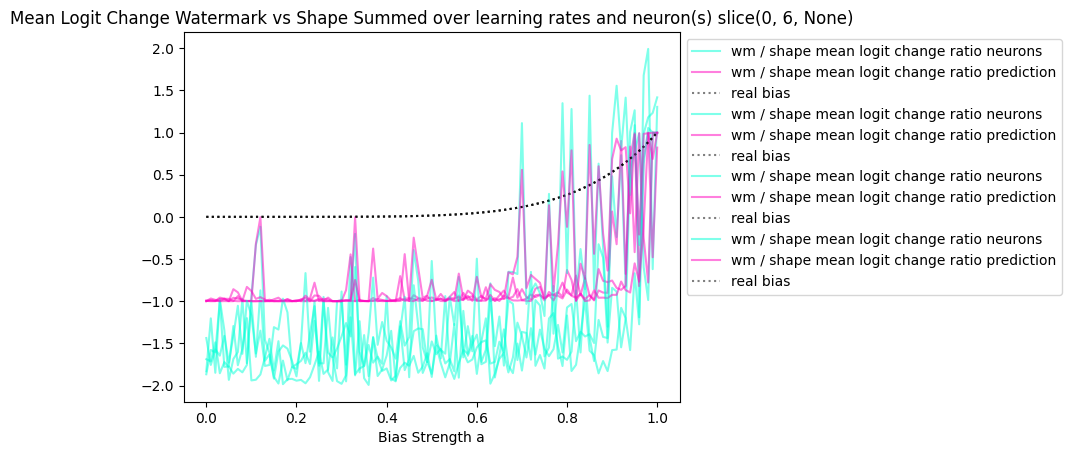

In [242]:
def plot_linear_layer(items, biasitems, neuron, f1, f2):
    summed_wm = [np.sum(a["crp_mean_logit_change"][f1]) for a in items]
    summed_sh = [np.sum(a["crp_mean_logit_change"][f2]) for a in items]
    summed_p_wm = [a["pred_mean_logit_change"][f1] for a in items]
    summed_p_sh = [a["pred_mean_logit_change"][f2] for a in items]
    summed_neurons = [
        (summed_wm[i] - (summed_sh[i] + 1e-10)) for i in range(len(summed_wm))
    ]
    summed_prediction = [
        (summed_p_wm[i] - (summed_p_sh[i] + 1e-10)) for i in range(len(summed_p_sh))
    ]
    plt.plot(
        biasitems,
        summed_neurons,
        color=colors[5],
        label=f"wm / shape mean logit change ratio neurons",
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        summed_prediction,
        color=colors[9],
        label=f"wm / shape mean logit change ratio prediction",
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        [i**6 for i in biasitems],
        color="#000",
        label="real bias",
        linestyle="dotted",
        alpha=0.5,
    )


neuron = slice(0, 6)
f1 = 0
f2 = 1
plot_linear_layer(datas[0], filtbiases, neuron, f1, f2)
plot_linear_layer(datas[1], filtbiases, neuron, f1, f2)
plot_linear_layer(datas[2], filtbiases, neuron, f1, f2)
plot_linear_layer(datas[3], filtbiases, neuron, f1, f2)
plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Bias Strength a")
plt.title(
    f"Mean Logit Change Watermark vs Shape Summed over learning rates and neuron(s) {neuron}"
)